In [1]:
import fastbook
fastbook.setup_book()

In [3]:
from fastai.vision.all import *
from fastbook import *
matplotlib.rc('image', cmap='Greys')

**Get data**

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)

In [6]:
path

Path('/storage/data/mnist_sample')

In [12]:
(path/'train').ls()

(#2) [Path('/storage/data/mnist_sample/train/7'),Path('/storage/data/mnist_sample/train/3')]

In [28]:
train_threes = (path/'train'/'3').ls().sorted()
train_sevens = (path/'train'/'7').ls().sorted()
train_threes

(#6131) [Path('/storage/data/mnist_sample/train/3/10.png'),Path('/storage/data/mnist_sample/train/3/10000.png'),Path('/storage/data/mnist_sample/train/3/10011.png'),Path('/storage/data/mnist_sample/train/3/10031.png'),Path('/storage/data/mnist_sample/train/3/10034.png'),Path('/storage/data/mnist_sample/train/3/10042.png'),Path('/storage/data/mnist_sample/train/3/10052.png'),Path('/storage/data/mnist_sample/train/3/1007.png'),Path('/storage/data/mnist_sample/train/3/10074.png'),Path('/storage/data/mnist_sample/train/3/10091.png')...]

In [36]:
valid_threes = (path/'valid'/'3').ls().sorted()
valid_sevens = (path/'valid'/'7').ls().sorted()

In [31]:
Image.open(train_threes[1])

**Stack it up in tensors**

In [33]:
train_three_tensors = [tensor(Image.open(o)) for o in train_threes]
train_seven_tensors = [tensor(Image.open(o)) for o in train_sevens]

In [34]:
train_stacked_threes = torch.stack(three_tensors).float()/255
train_stacked_sevens = torch.stack(seven_tensors).float()/255

In [37]:
train_three_tensors = [tensor(Image.open(o)) for o in valid_threes]
train_seven_tensors = [tensor(Image.open(o)) for o in valid_sevens]

In [39]:
valid_stacked_threes = torch.stack(train_three_tensors).float()/255
valid_stacked_sevens = torch.stack(train_seven_tensors).float()/255

**Create train and validation datasets**

In [85]:
x_train = torch.cat([train_stacked_threes, train_stacked_sevens]).view(-1, 28*28)
y_train = tensor([1]*len(train_threes) + [0]*len(train_sevens)).unsqueeze(1)

In [84]:
x_valid = torch.cat([valid_stacked_threes, valid_stacked_sevens]).view(-1, 28*28)
y_valid = tensor([1]*len(valid_threes) + [0]*len(valid_sevens)).unsqueeze(1)

In [86]:
t_dset = list(zip(x_train, y_train))
v_dset = list(zip(x_valid, y_valid))

**Initialize parameters function**

In [87]:
def init_params(size, var=1.0): return (torch.randn(size)*var).requires_grad_()

In [88]:
weights = init_params((28*28, 1))
bias = init_params(1)

In [89]:
bias

tensor([0.5713], requires_grad=True)

> Same weight, bias for each input image

**Basic linear function**

In [90]:
def mylinear(xb): return xb@weights + bias

In [91]:
# Predict and evaluate
preds = mylinear(x_train)
preds

tensor([[ 7.4808],
        [22.1544],
        [ 9.5814],
        ...,
        [ 8.0364],
        [ 9.0833],
        [-0.8914]], grad_fn=<AddBackward0>)

In [92]:
corrects = (preds>0.0).float() == y_train
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [ True]])

In [93]:
corrects.float().mean().item()

0.5128267407417297

*Does changing a weight by a small amount change the accurracy?**

In [97]:
weights[0] *= 1.0001
preds = mylinear(x_train)
((preds>0.0) == y_train).float().mean().item()

0.5128267407417297

So we can't take corrects as our loss fn, we need something that changes with minute changes in a weight

**Our loss function**

In [99]:
def mnist_loss(preds, targets):
    preds = preds.sigmoid()
    return torch.where((targets==1), 1-preds, preds).mean()

**Loading datasets in mini-batches**

In [258]:
t_dl = DataLoader(t_dset, batch_size=256, shuffle=False)
v_dl = DataLoader(v_dset, batch_size=256, shuffle=True)

**Some practice**

In [151]:
weights = init_params((28*28, 1))
bias= init_params(1)

In [132]:
inp = x_train[:4]
inp.shape

torch.Size([4, 784])

In [133]:
preds = mylinear(inp)
preds

tensor([[ -1.8194],
        [ -9.1876],
        [ -2.6484],
        [-15.1669]], grad_fn=<AddBackward0>)

In [284]:
y_train[:4]

tensor([[1],
        [1],
        [1],
        [1]])

In [286]:
loss = mnist_loss(preds, y_train[:4])
loss

tensor(0.9486, grad_fn=<MeanBackward0>)

In [135]:
loss.backward()

In [136]:
weights.grad.shape, bias.grad.shape

(torch.Size([784, 1]), torch.Size([1]))

**Gradient calculation**

In [137]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [138]:
calc_grad(inp, y_train[:4], mylinear)
weights.grad.mean(), bias.grad

(tensor(-0.0130), tensor([-0.0909]))

In [139]:
calc_grad(inp, y_train[:4], mylinear)
weights.grad.mean(), bias.grad

(tensor(-0.0195), tensor([-0.1364]))

**Resetting gradients to zero is important s loss.backward adds up the previous gradients**

In [141]:
weights.grad.zero_()
bias.grad.zero_();

**Now let's create epoch traiining func with weight updation in each epoch**

In [142]:
def train_epoch(model, lr, params):
    for xb, yb in t_dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad.data*lr
            p.grad.zero_()

**Defining epoch accuracy**

In [143]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    return ((preds>0.5) == yb).float().mean()

In [145]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in v_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [146]:
validate_epoch(mylinear)

0.2545

**Let's train for one more epoch**

In [152]:
lr = 0.1
params = weights, bias
train_epoch(mylinear, lr, params)
validate_epoch(mylinear)

0.5108

In [154]:
for i in range(20):
    train_epoch(mylinear, lr, params)
    print(validate_epoch(mylinear), end =' ')

0.9203 0.9222 0.9262 0.9271 0.9271 0.9276 0.9291 0.9296 0.9301 0.9315 0.933 0.9335 0.934 0.935 0.935 0.9359 0.9379 0.9398 0.9413 0.9418 

**Optimizer Class**

In [179]:
class MyOptim:
    def __init__(self, params, lr): self.params, self.lr = list(params), lr
        
    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr
            
    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

**PyTorch Linear Model**

In [171]:
linear_model = nn.Linear(28*28,1)

In [172]:
w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

**Instantiate optimizer object**

In [173]:
opt = MyOptim(linear_model.parameters(), lr)

In [180]:
def train_epoch(model):
    for xb, yb in t_dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [181]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [176]:
train_model(linear_model, 20)

0.9657 0.9677 0.9691 0.9696 0.9696 0.9696 0.9701 0.9701 0.9711 0.9711 0.9716 0.9726 0.9736 0.974 0.9745 0.9745 0.9745 0.975 0.975 0.975 

**Replacing MyOptim class with SGD we write our learning as**

In [275]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), 0.01)
train_model(linear_model, 20)

0.9108 0.9245 0.9396 0.9494 0.9535 0.9577 0.9603 0.9603 0.9598 0.9597 0.9613 0.9618 0.9617 0.9617 0.9622 0.9627 0.9637 0.9637 0.9642 0.9641 

**Using DataLoders and learner.fit instead of train_model func**

In [259]:
dls = DataLoaders(t_dl, v_dl)

In [260]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
               loss_func=mnist_loss, metrics=batch_accuracy)

In [261]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.207152,0.368858,0.556919,00:00
1,0.118368,0.182836,0.871933,00:00
2,0.082302,0.108197,0.933759,00:00
3,0.064897,0.080763,0.954367,00:00
4,0.055416,0.067329,0.962218,00:00
5,0.049653,0.059428,0.962709,00:00
6,0.045783,0.054211,0.964671,00:00
7,0.042962,0.050489,0.966634,00:00
8,0.040774,0.047683,0.967615,00:00
9,0.039000,0.045480,0.968106,00:00


**Changing linear model to a neural net**

In [287]:
my_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [288]:
learn = Learner(dls, my_net, opt_func=SGD,
               loss_func=mnist_loss, metrics=batch_accuracy)

In [289]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.316929,0.404704,0.506379,00:00
1,0.148064,0.226106,0.812071,00:00
2,0.081690,0.114054,0.916585,00:00
3,0.053511,0.077281,0.942100,00:00
4,0.040508,0.060590,0.958292,00:00
5,0.033907,0.051192,0.965162,00:00
6,0.030133,0.045250,0.965653,00:00
7,0.027688,0.041168,0.966634,00:00
8,0.025928,0.038198,0.969578,00:00
9,0.024565,0.035925,0.971541,00:00


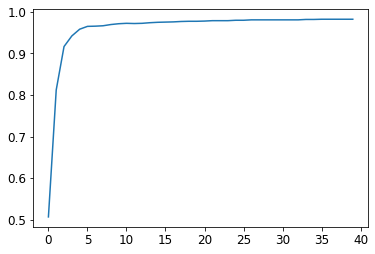

In [290]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [266]:
learn.recorder.values[-1][2]

0.98233562707901

In [218]:
path

Path('/storage/data/mnist_sample')

**Using resnet18 instead**

In [296]:
dls2 = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls2, resnet18, pretrained=False,
                   loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.085649,0.022008,0.992640,00:09


In [277]:
doc(F.cross_entropy)

In [281]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.randint(5, (3,), dtype=torch.int64)
loss = F.cross_entropy(input, target)
loss.shape

torch.Size([])